In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from cli.cmonitor import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
import netCDF4 as nc
d = nc.Dataset(r"/ssd_scratch/hcases/fixafn/faf6c-newbase_faf5y1_tightrtol_pvodefail/BOUT.debug.0.nc")

In [24]:
ds.dims

Frozen({'x': 20, 'theta': 50})

In [2]:
# case = "faf6c-newbase_faf5y1_tightrtol_pvodefail"
# case = "faf7dc-legcond_asymp2_long_pvodefail"
cases = {
    "base" : "faf6d-newbase_faf5y1_tightrtol_pvodefail_tuneres",
    "test" : "faf7dd-legcond_asymp2_long_pvodefail_tuneres"
}

toload = [ 
    # dict(name="base", id="faf6a-newbase_faf5y1_tightrtol", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="bool", id="faf7a-legcond_bool", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp4", id="faf7b-legcond_asymp4", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp2", id="faf7c-legcond_asymp2", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp2_long", id="faf7d-legcond_asymp2_long", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp4_linfreeze_kappa", id="faf8b-asymp4_lifreeze_kappa", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp4_linfreeze_kappa", id="faf8b-asymp4_lifreeze_kappa", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp4_totfreeze_kappa", id="faf9a-asymp4_totfreeze_kappa", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="asymp4_totfreeze_kappa_dn", id="faf9c-asymp4_totfreeze_kappa_dn", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
    dict(name="base", id="faf6d-newbase_faf5y1_tightrtol_pvodefail_tuneres", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="test", id="faf7dd-legcond_asymp2_long_pvodefail_tuneres", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="asymp2", id="faf7c-legcond_asymp2", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="asymp2_pvode", id="faf7db-legcond_asymp2_long_pvode", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
]
         
# case = "faf7dd-legcond_asymp2_long_pvodefail_tuneres"

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

path = str(db.casepaths[case])
ds = xbout.open_boutdataset(datapath=f"{path}/BOUT.debug.*.nc", geometry='toroidal',
                            gridfilepath=db.get_grid_path(case),
                            inputfilepath=os.path.join(path, "BOUT.inp"),
                            info=False, 
                            # grid_kw=dict(drop_variables=["offset_3x3"]), 
                            #use_modules=False
                           )

ds = ds.squeeze()

/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(


In [5]:
if "Ne" in ds and "normalised_by" in ds.Ne.attrs:
    ds["Ne"] /= ds.Ne.attrs["normalised_by"]
    ds.Ne.attrs["normalised_by"]=1

def gettol(ds):
    try:
        atol = float(ds.options["solver:atol"])
    except KeyError:
        atol = 1e-12
    try:
        rtol = float(ds.options["solver:rtol"])
    except KeyError:
        rtol = 1e-5
    return atol, rtol


pre = "residuum_"
worst = {}
def get_res(ds, k):
        var = ds[k]
        res = ds[pre + k]
        atol, rtol = gettol(ds)
        err = abs(var) * rtol + atol
        where = abs(res) > err
        return res, err, where


def check_res(ds):
    keys = [k.split("_", 1)[1] for k in ds if k.startswith(pre)]
    for k in keys:
        print(f"Residuum for {k}:")
        res, err, where = get_res(ds, k)
        sumwhere = np.sum(where.compute())
        if not np.all(np.isfinite(err)):
            print(f"Not finite at {err.size - np.sum(np.isfinite(err))} of {err.size} points")
        if sumwhere:
            print(f"Above limit at {sumwhere} not fullfilled")
        else:
            print(f"Limit fullfilled everywhere")
        w = np.unravel_index(np.argmax(np.abs(res.values)), res.shape)
        print(f"Maximum residuum at {w}")
        worst[k] = w
        print("Maximum value is", np.max(err).values)
        
        
check_res(ds)

Residuum for NVd:
Limit fullfilled everywhere
Maximum residuum at (4, 21)
Maximum value is 8.988000758126807e-08
Residuum for NVd+:
Above limit at 19 not fullfilled
Maximum residuum at (2, 38)
Maximum value is 4.738276814349645e-06
Residuum for Nd:
Limit fullfilled everywhere
Maximum residuum at (3, 29)
Maximum value is 5.085327496597675e-06
Residuum for Nd+:
Limit fullfilled everywhere
Maximum residuum at (2, 5)
Maximum value is 7.084433565650967e-05
Residuum for Pd:
Limit fullfilled everywhere
Maximum residuum at (4, 20)
Maximum value is 1.267336083874954e-07
Residuum for Pd+:
Limit fullfilled everywhere
Maximum residuum at (2, 5)
Maximum value is 7.812164024671688e-05
Residuum for Pe:
Limit fullfilled everywhere
Maximum residuum at (2, 37)
Maximum value is 3.9457248362355454e-05


In [15]:
worst.keys()

dict_keys(['NVd', 'NVd+', 'Nd', 'Nd+', 'Pd', 'Pd+', 'Pe'])

In [26]:
[print(x) for x in ds.data_vars if x.startswith("residuum")]

residuum_NVd
residuum_NVd+
residuum_Nd
residuum_Nd+
residuum_Pd
residuum_Pd+
residuum_Pe


[None, None, None, None, None, None, None]

In [34]:
type(worst["Nd+"][1])

numpy.int64

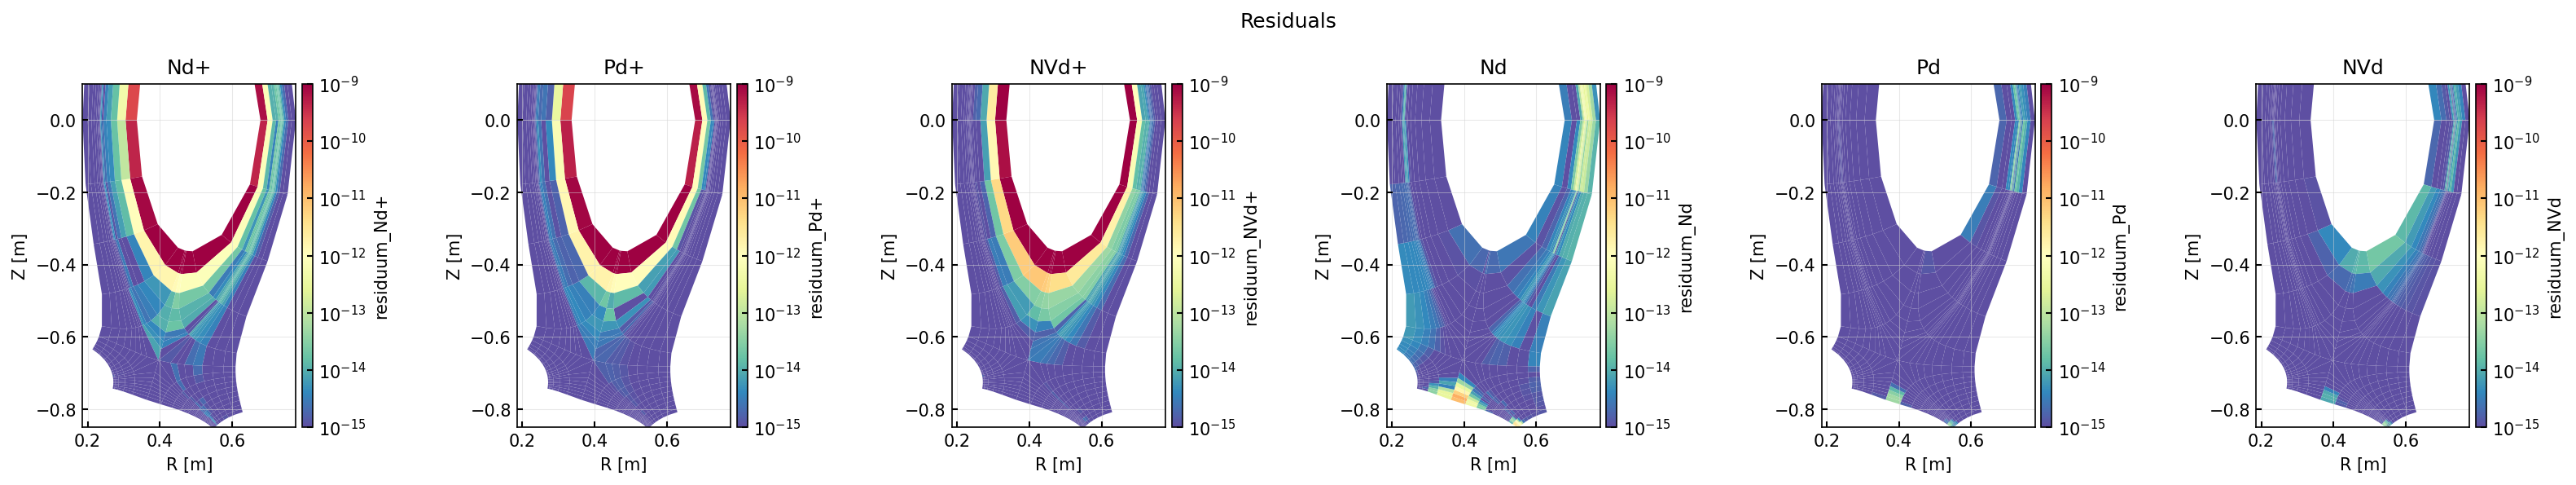

In [4]:

sel = {"x" : slice(2,-2)}

vmax = 1e-9
vmin = 1e-15

plot2d(
    [
        dict(data = abs(ds["residuum_Nd+"].isel(x = slice(2,-2))), title = "Nd+", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_Pd+"].isel(x = slice(2,-2))), title = "Pd+", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_NVd+"].isel(x = slice(2,-2))), title = "NVd+", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_Nd"].isel(x = slice(2,-2))), title = "Nd", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_Pd"].isel(x = slice(2,-2))), title = "Pd", vmin = vmin, vmax = vmax),
        dict(data = abs(ds["residuum_NVd"].isel(x = slice(2,-2))), title = "NVd", vmin = vmin, vmax = vmax),
        # dict(data = ds["Kdd+_cx"] , vmin = 1e2, vmax = 1e6),
        # dict(data = ds["Nd"]),
        # dict(data = ds["Pd"]),
        # dict(data = ds["Dnnd"], vmin = 10, vmax = 1e5, logscale = True),
        ], 
        ylim = (-0.85, 0.1),
        title = "Residuals",
        clean_guards = False,
        separatrix = False,
        w_pad = -2.5)

KeyError: 'j2_2g'

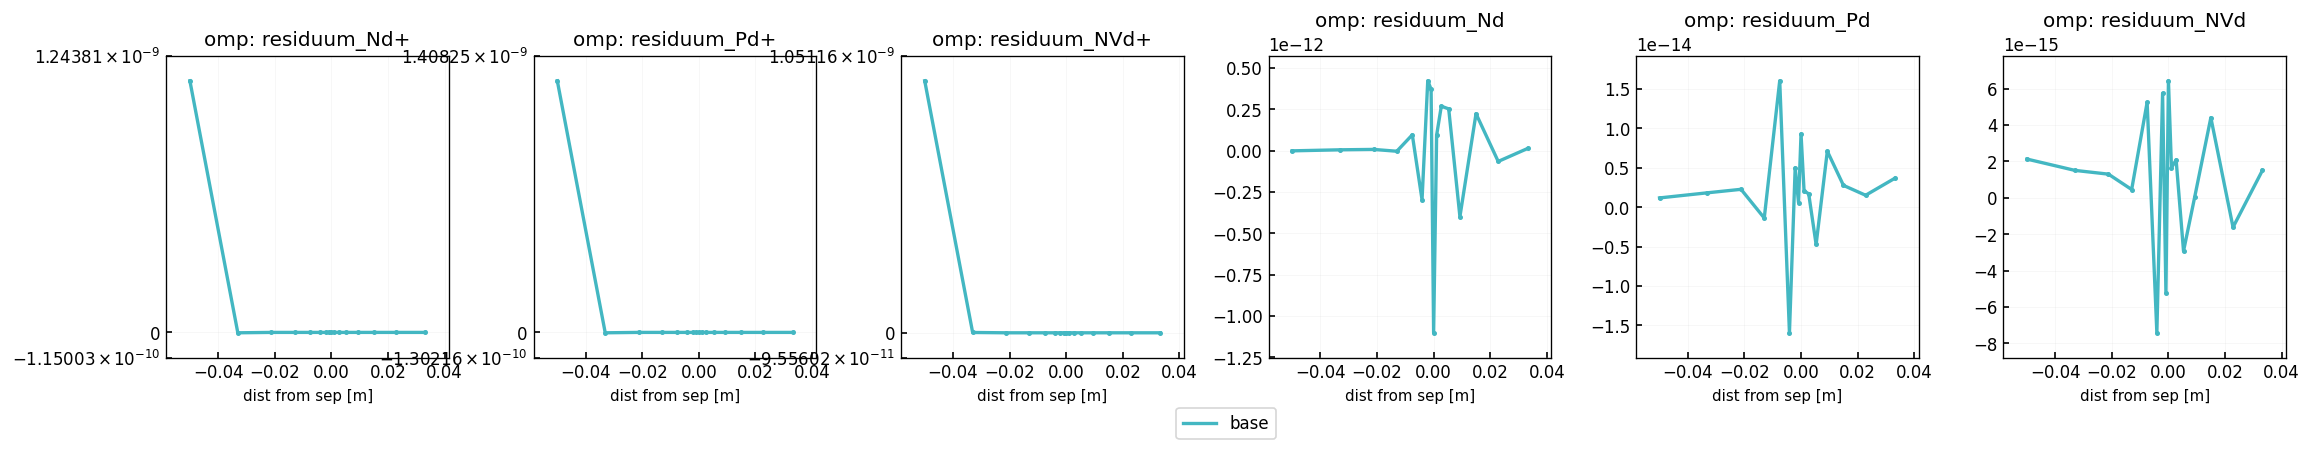

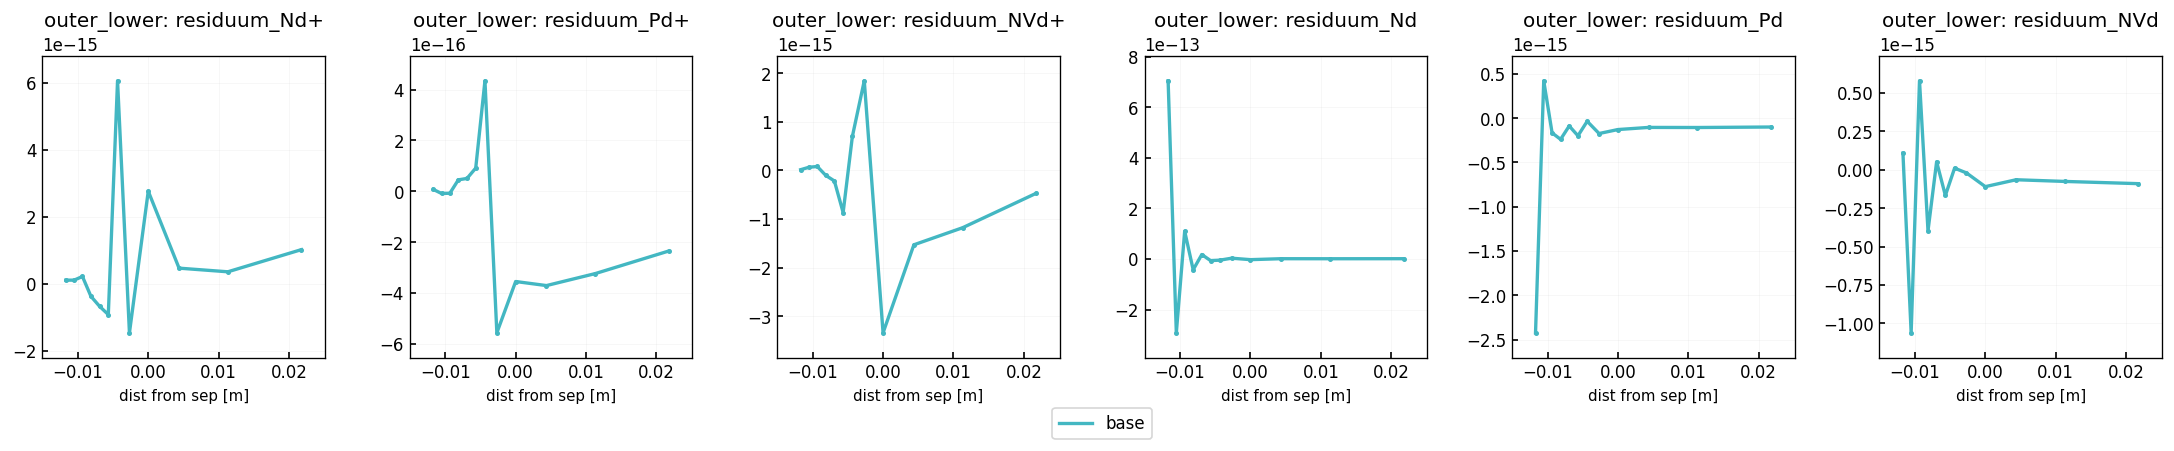

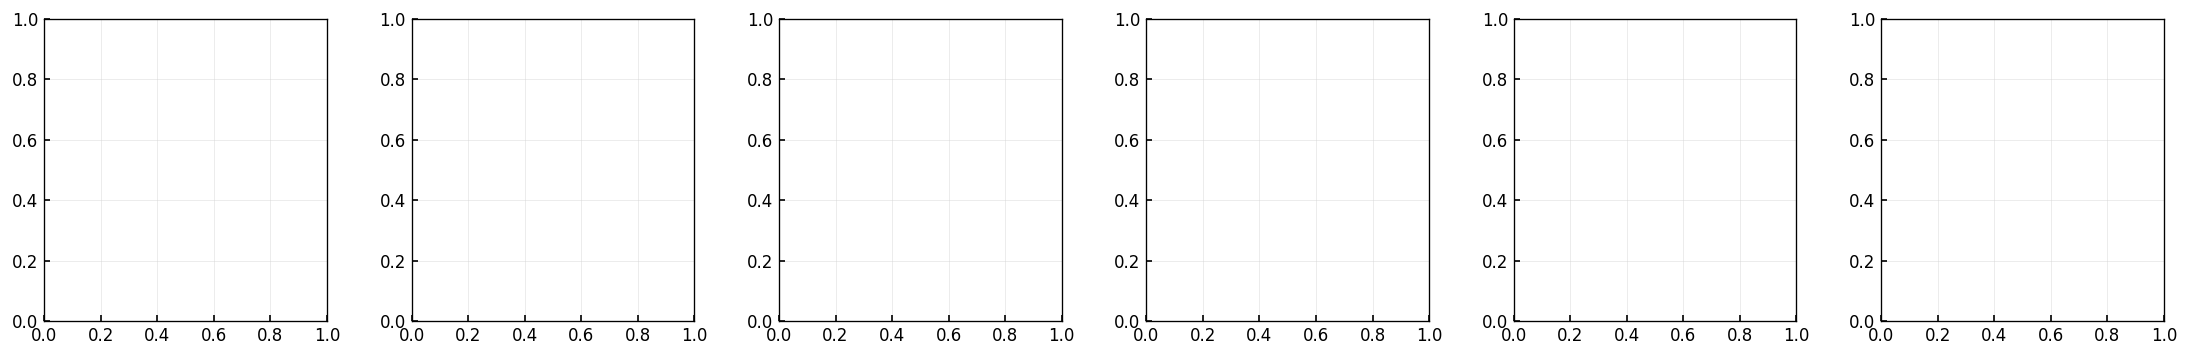

In [62]:
toplot = {}

toplot["base"] = ds.isel(x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["residuum_Nd+", "residuum_Pd+", "residuum_NVd+", "residuum_Nd", "residuum_Pd", "residuum_NVd"],
    # params = ["Nd", "Dnnd"],
    regions = ["omp", "outer_lower", "field_line"],
)

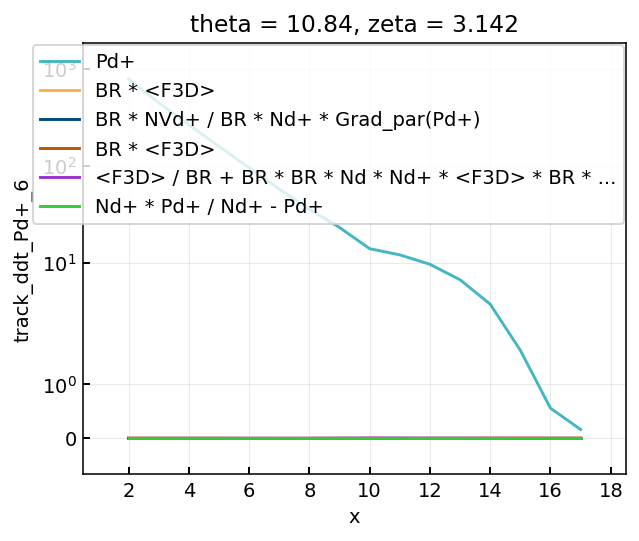

In [20]:
plt.figure()
k0 = "Pd+"
w = worst[k0]
isel = dict(x=slice(2,-2), theta=w[1])#, x=slice(2, -2))
for k in [k0] + [f"track_ddt_{k0}_{k}" for k in range(20)]:
    if k not in ds:
        continue
    label = ds[k].attrs.get("rhs.name", k)
    #print( ds[k].attrs)
    cutoff = 50
    if len(label) > cutoff:
        label=label[:cutoff-3] + "..."
    ds[k].isel(**isel).plot(label=label)
plt.yscale("symlog")
plt.legend()

if 0:
    plt.figure()
    for k in "Pe", "track_ddt_Pe_3", "track_ddt_Pe_5":
        np.log(np.abs(ds[k].isel(**isel))).plot(label=k)
    yll, ylu = plt.ylim()
    ylu -= yll
    ylu /= 4
    yll += ylu * 2
    for k in "Pe", "track_ddt_Pe_3", "track_ddt_Pe_5":
        (yll + ylu * np.sign(ds[k].isel(**isel))).plot(label="sign "+k)
    plt.legend()
#(ds.Pe.isel(**isel)).plot()
#(ds.track_ddt_Pe_3.isel(**isel)/1e-3).plot()
#(ds.track_ddt_Pe_5.isel(**isel)/1e-3).plot()


# Old

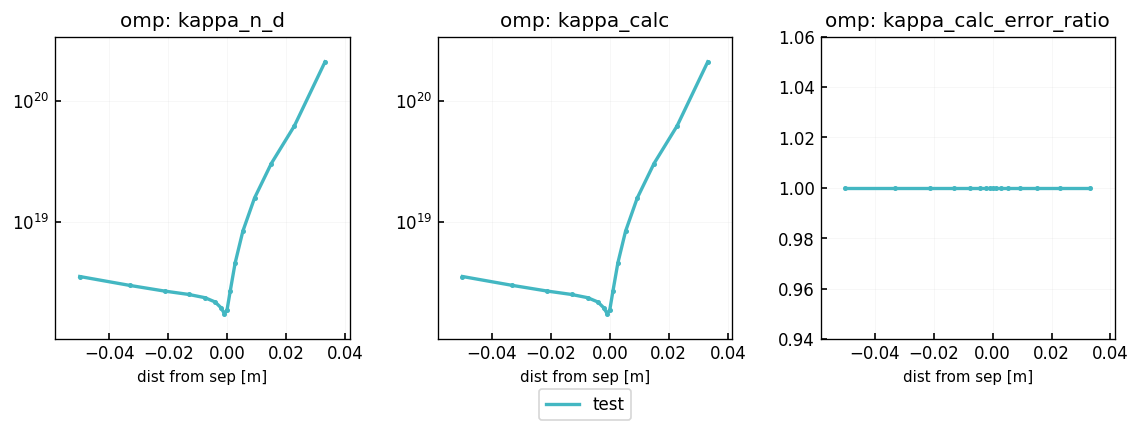

In [6]:
toplot = {}
for case in cs:
# for case in ["test_legacy", "test_afn"]:

    ds = cs[case].ds
    ds["kappa_ratio"] = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"]
    ds["kappa_unlim_calc"] = ds["Dnn_unlimd"] * ds["Nd"] * 5/2
    ds["kappa_unlim_calc_error"] = ds["kappa_n_unlimited_d"] / ds["kappa_unlim_calc"]
    
    gamma = 2
    ds["kappa_calc"] = ds["kappa_n_unlimited_d"] * (1 + (ds["kappa_n_unlimited_d"]/ds["kappa_n_max_d"])**(gamma))**(-1/gamma)
    ds["kappa_calc_error_ratio"] = ds["kappa_calc"] / ds["kappa_n_d"]
    if "t" in ds.dims: ds = ds.isel(t=-1)
    toplot[case] = ds.isel(x = slice(2,-2))

    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    # params = ["kappa_n_d", "kappa_n_unlimited_d", "Nd", "Dnnd", "kappa_n_max_d", "Dnn_unlimd"],
    params = ["kappa_n_d", "kappa_calc", "kappa_calc_error_ratio"],
    # params = ["Nd", "Dnnd"],
    # regions = ["omp", "imp", "outer_lower", "field_line"],
    regions = ["omp"]
)

In [ ]:
  alternative_precon = options["alternative_precon"]
                          .doc("Use alternative preconditioner?")
                          .withDefault<bool>(false);



  if (alternative_precon) {
    coef = -gamma * Dnn - gamma * kappa_n;
    inv->setCoefD(coef);
  }



In [4]:
[print(x) for x in ds.data_vars if "kappa" in x]

kappa_d
kappa_n_Dnchained_d
kappa_n_d
kappa_n_max_d
kappa_n_unlimited_d
kappa_par_d+
kappa_par_e
kappa_ratio
kappa_unlim_calc
kappa_unlim_calc_error


[None, None, None, None, None, None, None, None, None, None]

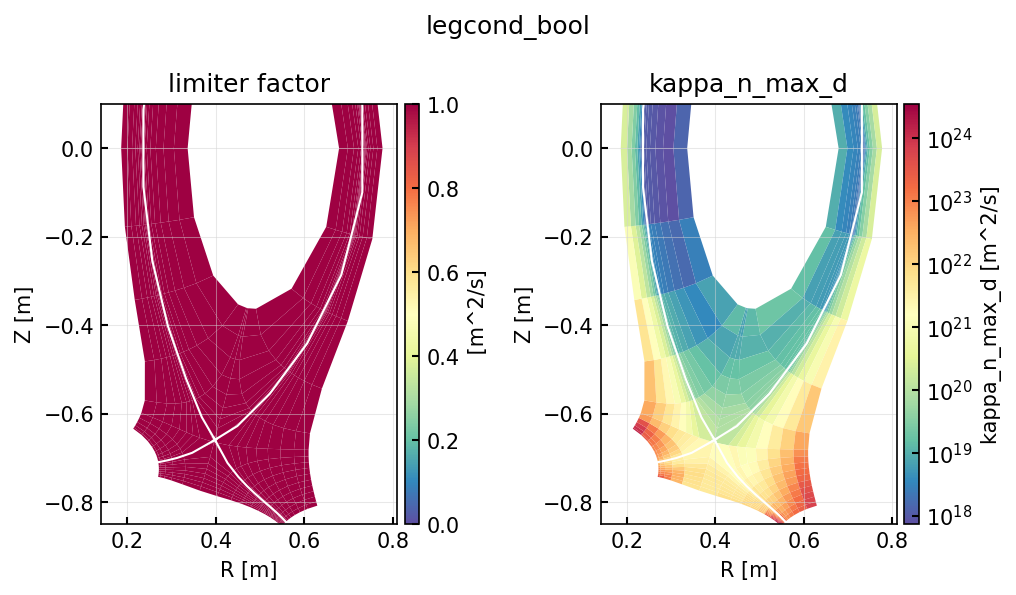

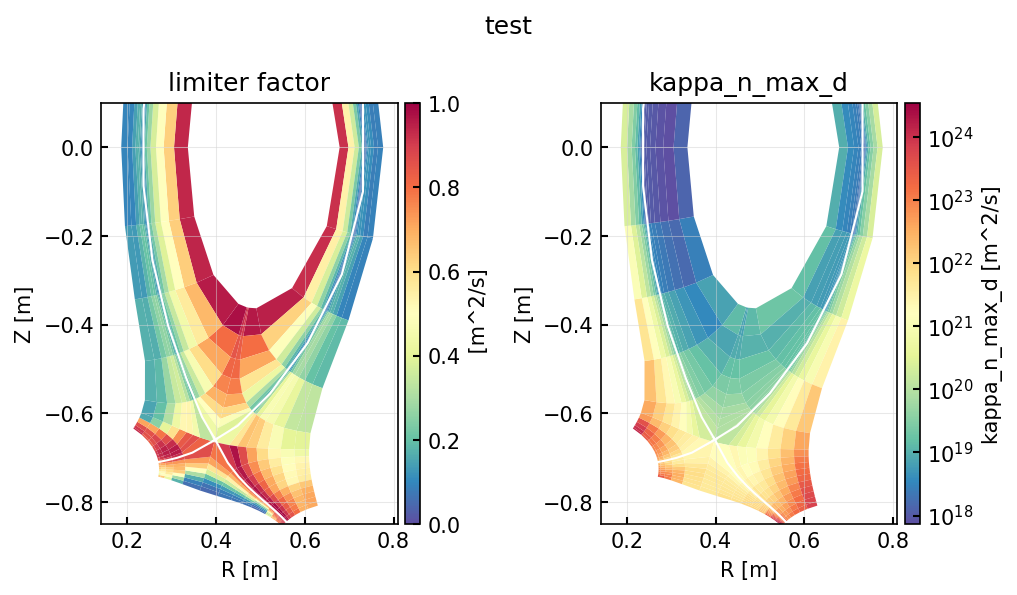

In [10]:
# for case in ["a1_mfp1e-4"]:
for case in cs:
# for case in ["base", "no_rnn_flim1"]:

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    plot2d(
        [
            dict(data = ds["kappa_n_d"] / ds["kappa_n_unlimited_d"], title = "limiter factor", vmin = 0, vmax = 1, logscale = False),
            dict(data = ds["kappa_n_max_d"] , vmin = None, vmax = None),

            ], 
            ylim = (-0.85, 0.1),
            title = f"{case}")

In [ ]:
G = np.linspace(0,2000, 5000)
Gmax = 1000
gamma = 1

def make_glim(gamma):
    return G * (1 + (G/Gmax)**gamma)**(-1/gamma)


# plt.hlines(2000, G[0], G[-1], label = "Max", ls = "--", colors = "black")
plt.hlines(Gmax, G[0], G[-1], label = "Limit", ls = ":", colors = "black")
plt.vlines(Gmax, 0, Gmax, ls = ":", colors = "black")

plt.plot(G, make_glim(1), label = "gamma = 1")
plt.plot(G, make_glim(2), label = "gamma = 2")
plt.plot(G, make_glim(5), label = "gamma = 4")
plt.plot(G, make_glim(10), label = "gamma = 10")

plt.xlabel("Flux")
plt.legend(loc = "upper left", bbox_to_anchor=(1,1))
plt.ylabel("Limited flux")

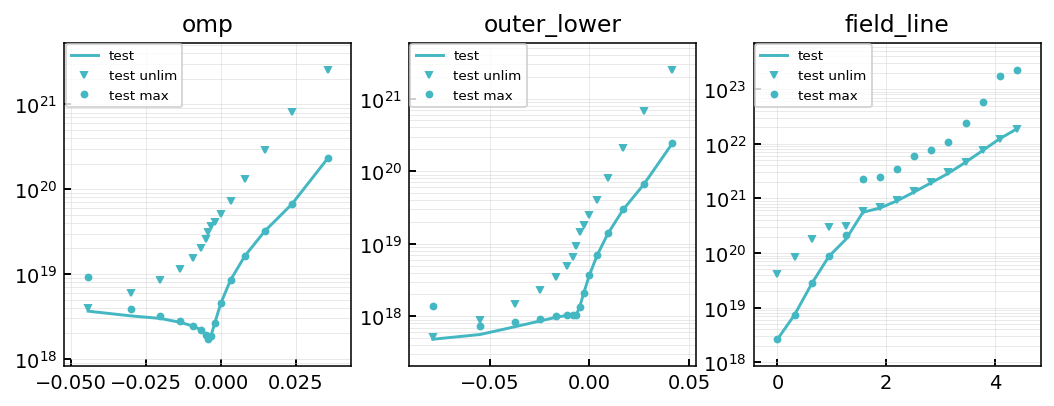

In [3]:
fig, axes = plt.subplots(1,3, figsize = (9,3))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


for i, case in enumerate(cs):
# for i, case in enumerate(["base"]):

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)

    regions = dict(
        omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2)).squeeze(),
        outer_lower = ds.hermesm.select_region("inner_midplane_a").isel(x=slice(2,-2)).squeeze(),
        field_line = ds.hermesm.select_custom_sol_ring(ds.metadata["ixseps1"], "outer_lower").squeeze()
    )

    

    for j, region in enumerate(regions):
        reg = regions[region]

        if region == "field_line":
            dist = reg.coords["theta"] - reg.coords["theta"][0]
        else:
            R = reg["dr"].cumsum()
            dist = (R - R[ds.metadata["ixseps1"]])

        ax = axes[j]
        ax.plot(dist, reg["kappa_n_d"], color = colors[i], label = f"{case}")
        ax.plot(dist, reg["kappa_n_unlimited_d"], color = colors[i], marker = "v", lw = 0, ms = 3,  label = f"{case} unlim")
        if case != "base": ax.plot(dist, reg["kappa_n_max_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")
        ax.set_title(region)
        # ax.plot(dist, reg["kappa_n_Dnchained_d"], color = colors[i], marker = "o", lw = 0, ms = 3, label = f"{case} max")

        ax.legend(fontsize = "x-small")
        ax.set_yscale("log")

